# Import libraries

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
)
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
import pickle
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import re

# set random seed
np.random.seed(42)

# Read Data

In [93]:
df = pd.read_csv("Static_dataset.csv")
df

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,33:51.5,18,3,0,16,0,2.338623,2,3,10,5.333333,alma,almaalomah,14,1,0
268070,36:02.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,37:21.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,24:25.1,16,0,0,14,0,3.249687,2,2,13,7.500000,radio,radio-vintage,14,0,0


# EDA

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

## Null values

In [71]:
df.isna().sum()

timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        8
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

## Duplicated rows

In [63]:
df.duplicated().sum()

91803

## Imbalance

* **The ratio of attacks to normal is 54.90% to 45.10%. This is a slight imbalance, but not enough to warrant any special treatment.**

* **Will recheck after data cleaning and droping duplicates**

In [64]:
df["Target Attack"].value_counts()

Target Attack
1    147179
0    120895
Name: count, dtype: int64

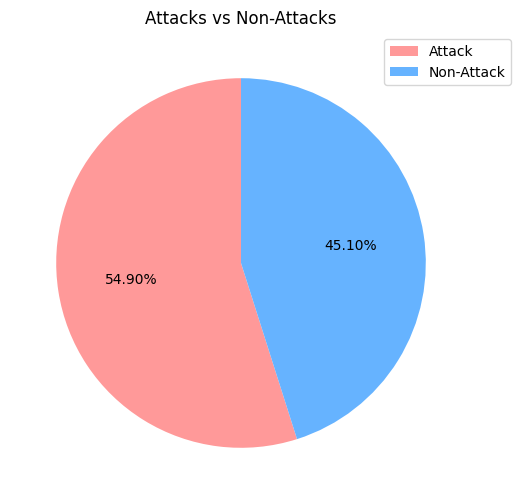

In [65]:
plt.figure(figsize=(6, 6))
plt.pie(
    df["Target Attack"].value_counts(),
    autopct="%1.2f%%",
    startangle=90,
    colors=["#ff9999", "#66b3ff"],
)
plt.title("Attacks vs Non-Attacks")
plt.legend(["Attack", "Non-Attack"], loc="upper right", bbox_to_anchor=(1.1, 1))

plt.show()

## Statistical analysis

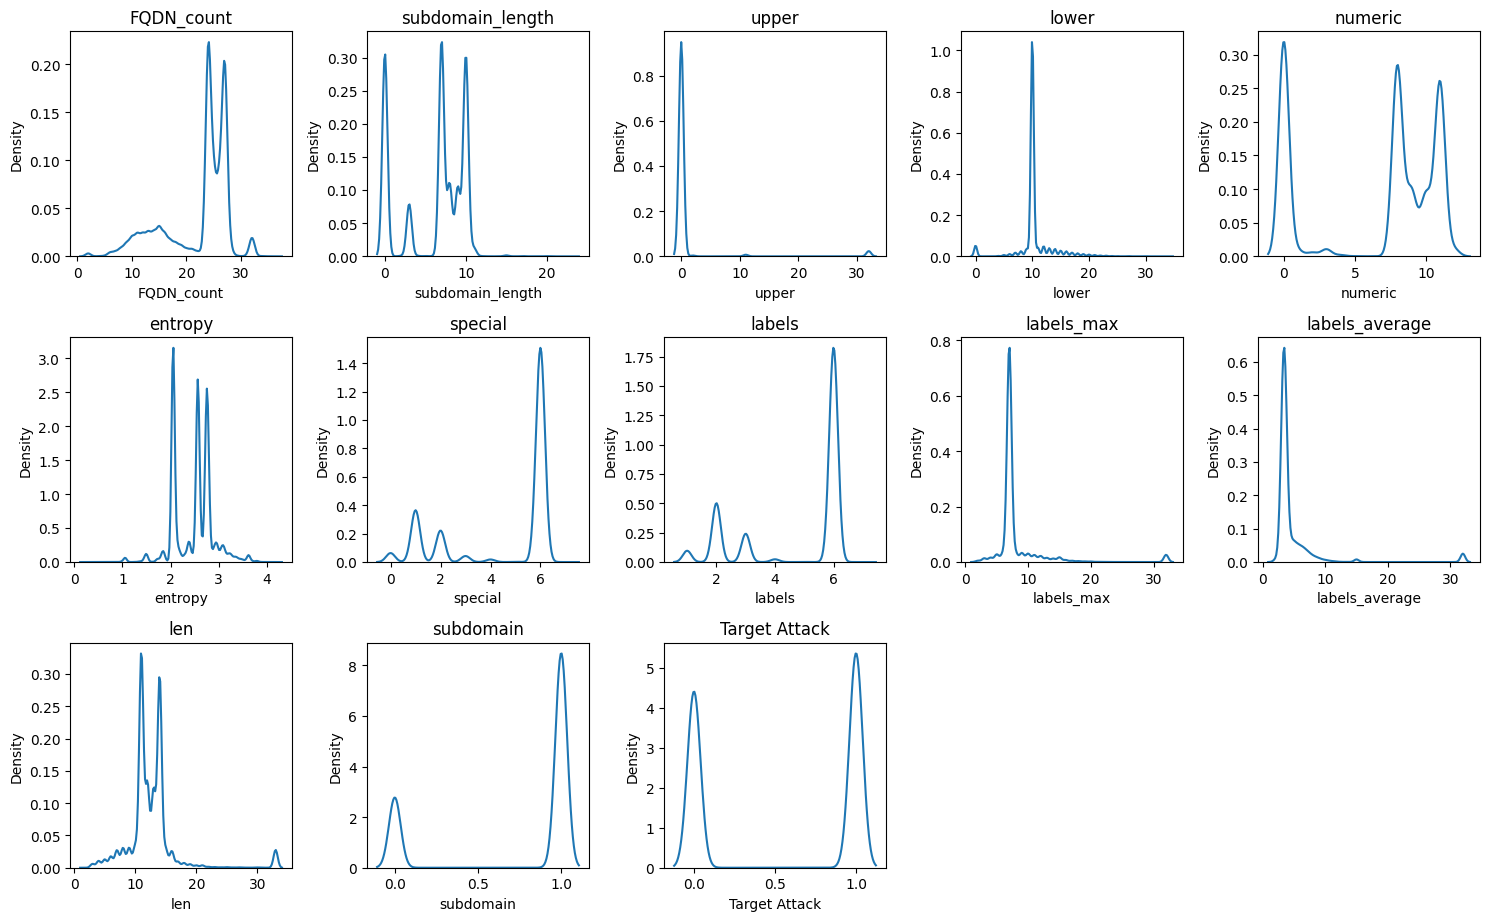

In [66]:
numerical_columns = df.select_dtypes(include="number").columns.tolist()
num_plots = len(numerical_columns)
num_rows, num_cols = 5, 5

plt.figure(figsize=(15, 15))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.kdeplot(data=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [67]:
df.describe()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
count,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000
mean,22.286596,6.059021,0.845420,10.410014,6.497586,2.485735,4.533577,4.788823,8.252233,4.802239,12.576714,0.753497,0.549024
std,6.001205,3.899505,4.941929,3.207725,4.499866,0.407709,2.187683,1.803256,4.415355,4.573066,4.177828,0.430975,0.497592
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000
25%,18.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000,0.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,10.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000,1.000000
max,36.000000,23.000000,32.000000,34.000000,12.000000,4.216847,7.000000,7.000000,32.000000,32.000000,33.000000,1.000000,1.000000


## Skewness

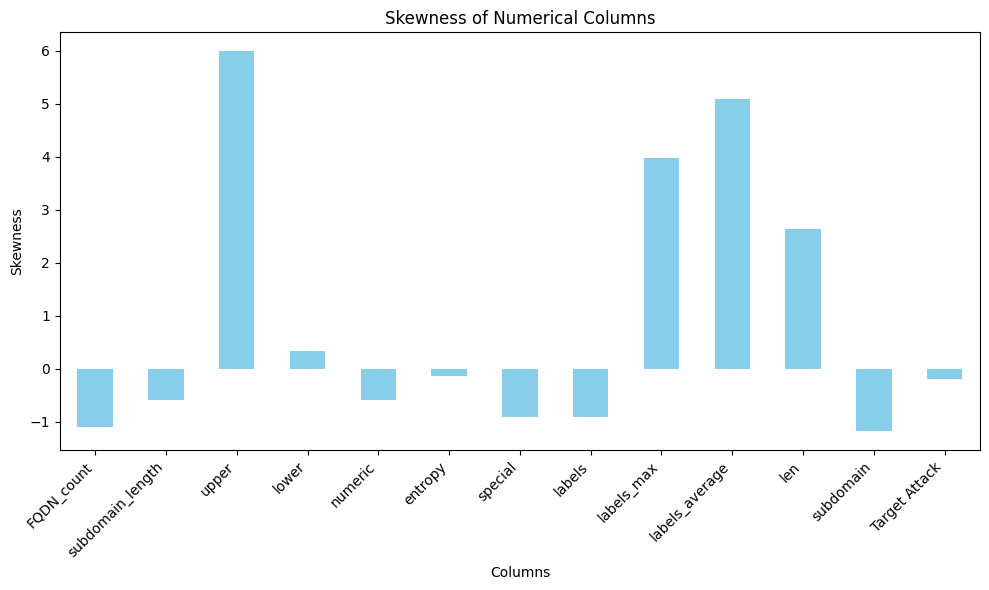

In [68]:
skewness = df.drop(["timestamp", "longest_word", "sld"], axis=1).skew()

# Plotting
plt.figure(figsize=(10, 6))
skewness.plot(kind="bar", color="skyblue")
plt.title("Skewness of Numerical Columns")
plt.xlabel("Columns")
plt.ylabel("Skewness")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Wordclouds

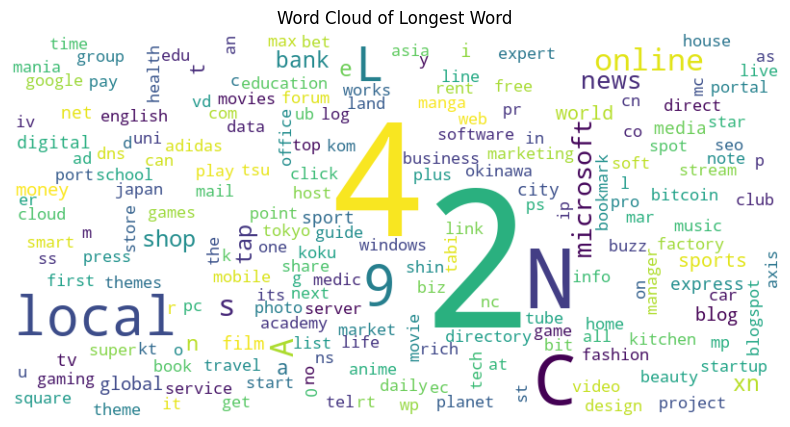

In [69]:
longest_word_column = df["longest_word"]
longest_word_column = longest_word_column.apply(lambda x: str(x))

word_counts = longest_word_column.value_counts()

wordcloud = WordCloud(
    width=800, height=400, random_state=21, max_font_size=200, background_color="white"
).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Longest Word")
plt.show()

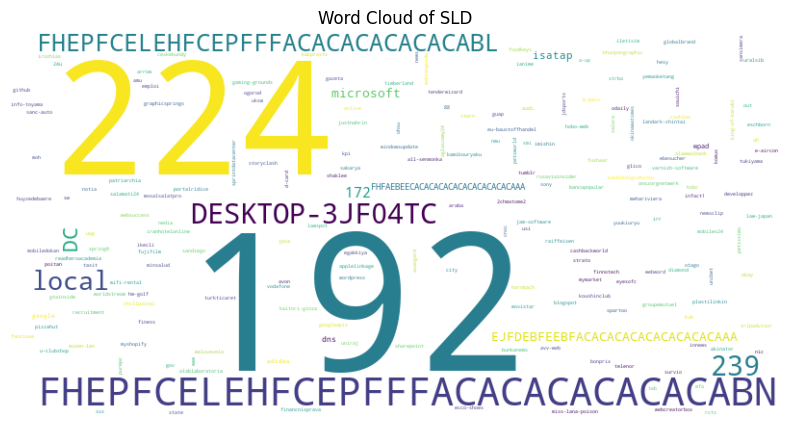

In [70]:
longest_word_column = df["sld"]
longest_word_column = longest_word_column.apply(lambda x: str(x))

word_counts = longest_word_column.value_counts()

wordcloud = WordCloud(
    width=800, height=400, random_state=21, max_font_size=200, background_color="white"
).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of SLD")
plt.show()

# Data Cleaning

In [72]:
# Drop duplicates
df = df.drop_duplicates()


# Drop Null values and reset index
df = df.dropna().reset_index(drop=True)


# Change the timestamp column to seconds
df["timestamp"] = (
    pd.to_datetime(df["timestamp"], format="%M:%S.%f").dt.minute * 60
    + pd.to_datetime(df["timestamp"], format="%M:%S.%f").dt.second
    + pd.to_datetime(df["timestamp"], format="%M:%S.%f").dt.microsecond / 1e6
).astype(float)

In [73]:
# replace the values in the longest_word column with the length of the longest word
df.loc[:, "longest_word"] = df["longest_word"].apply(
    lambda x: len(str(x)) if not str(x).isdigit() else x
)


# replace the values in the sld column with the frequency of the sld
value_counts = df["sld"].value_counts()
df.loc[:, "sld"] = df["sld"].map(value_counts)

In [74]:
df

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,3379.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,64258,14,1,1
1,443.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,64258,14,1,1
2,1395.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,64258,13,1,0
3,291.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,64258,14,1,1
4,764.0,15,9,0,11,0,2.929439,4,3,5,4.333333,5,1019,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176258,1524.4,24,7,0,10,8,2.054029,6,6,7,3.166667,4,40968,11,1,0
176259,560.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,64258,14,1,0
176260,1297.5,12,5,0,10,0,2.817711,2,3,5,3.333333,3,8,9,1,0
176261,2162.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,64258,14,1,0


### check for imbalance

In [75]:
df["Target Attack"].value_counts()

Target Attack
0    99650
1    76613
Name: count, dtype: int64

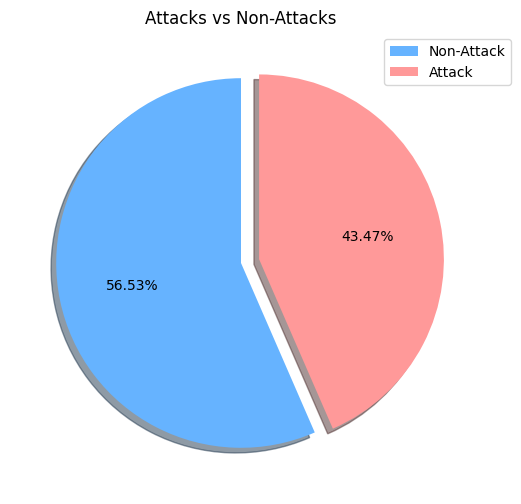

'\nAfter dropping duplicates and null values, the percentage of attacks and non-attacks is 43.37% and 56.63% respectively.\n\nStill not enough to warrant any special treatment.\n'

In [82]:
plt.figure(figsize=(6, 6))
plt.pie(
    df["Target Attack"].value_counts(),
    autopct="%1.2f%%",
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    explode=(0, 0.1),
    shadow=True,
)
plt.title("Attacks vs Non-Attacks")
plt.legend(["Non-Attack", "Attack"], loc="upper right", bbox_to_anchor=(1.1, 1))
plt.show()


"""
After dropping duplicates and null values, the percentage of attacks and non-attacks is 43.37% and 56.63% respectively.

Still not enough to warrant any special treatment.
"""

# Scale

In [17]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [18]:
X = df.drop(["Target Attack"], axis=1)
y = df["Target Attack"].astype(int)

# Feature Selection

## Mutual Information

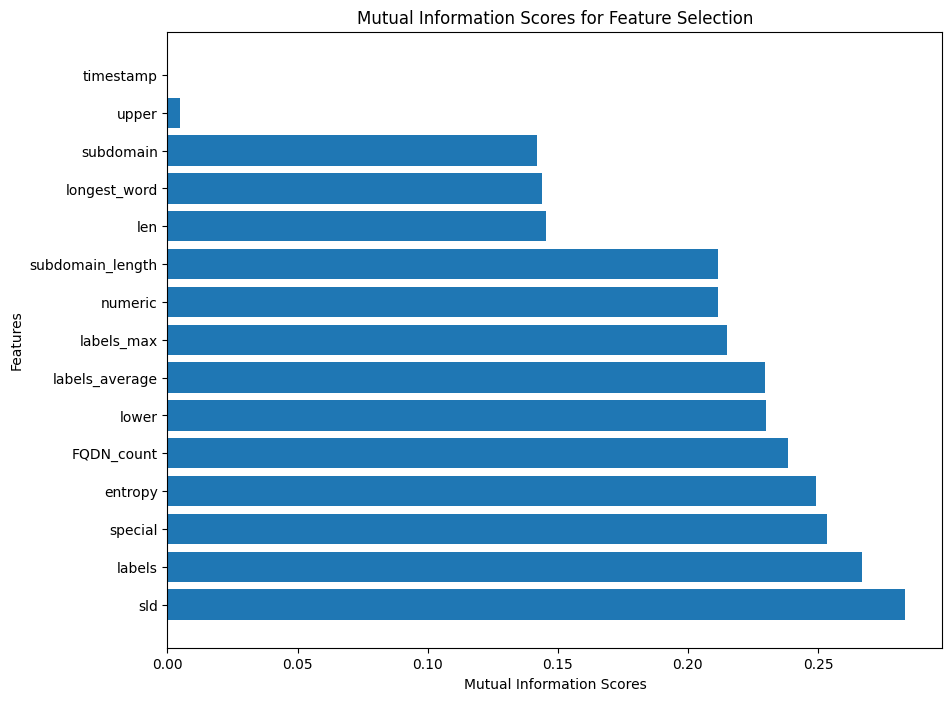

In [19]:
selector_mutual = SelectKBest(score_func=mutual_info_classif, k=8)
selector_mutual.fit(X, y)

# Get feature scores and sort the features
scores = selector_mutual.scores_
sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
sorted_features = [X.columns[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

# Save the top 8 features
MI_features = sorted_features[:8]

# Plot the sorted mutual information scores
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_scores)), sorted_scores, tick_label=sorted_features)
plt.xlabel("Mutual Information Scores")
plt.ylabel("Features")
plt.title("Mutual Information Scores for Feature Selection")
plt.show()

## ANOVA

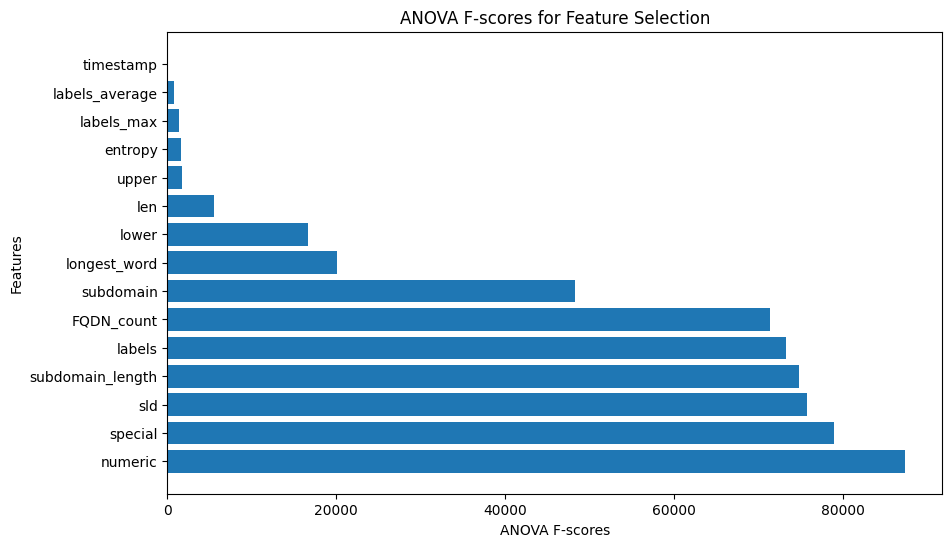

In [20]:
selector_ANOVA = SelectKBest(score_func=f_classif, k=8)
selector_ANOVA.fit(X, y)

# Get feature scores and sort the features
scores = selector_ANOVA.scores_
sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
sorted_features = [X.columns[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

# Save the top 8 features
ANOVA_features = sorted_features[:8]

# Plot the sorted ANOVA F-scores
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_scores)), sorted_scores, tick_label=sorted_features)
plt.xlabel("ANOVA F-scores")
plt.ylabel("Features")
plt.title("ANOVA F-scores for Feature Selection")
plt.show()

## Chi2

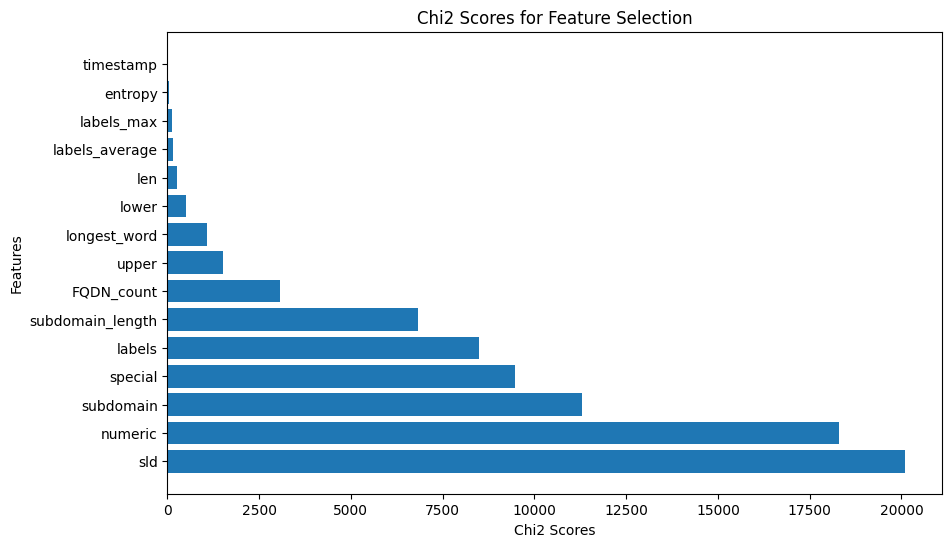

In [21]:
selector_chi2 = SelectKBest(score_func=chi2, k=8)
selector_chi2.fit(X, y)

# Get feature scores and sort the features
scores = selector_chi2.scores_
sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
sorted_features = [X.columns[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

# Save the top 8 features
chi2_features = sorted_features[:8]

# Plot the sorted chi2 scores
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_scores)), sorted_scores, tick_label=sorted_features)
plt.xlabel("Chi2 Scores")
plt.ylabel("Features")
plt.title("Chi2 Scores for Feature Selection")
plt.show()

# Models

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [23]:
def plot_cm(cm, class_names=["Normal", "Attack"]):
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=True,
        linewidths=0.5,
        square=True,
        annot_kws={"size": 12},
    )
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.xticks(ticks=[0.5, 1.5], labels=class_names, fontsize=12)
    plt.yticks(ticks=[0.5, 1.5], labels=class_names, fontsize=12)
    plt.show()

In [86]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    percision = precision_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print("Classification Report: \n", classification_report(y_test, y_pred))
    plot_cm(cm)

    return acc, f1, recall, percision

## Decision Tree

In [25]:
dt = DecisionTreeClassifier(random_state=42)

Classification Report: 
               precision    recall  f1-score   support

           0       0.62      0.70      0.66     19930
           1       0.54      0.45      0.49     15323

    accuracy                           0.59     35253
   macro avg       0.58      0.58      0.58     35253
weighted avg       0.59      0.59      0.59     35253



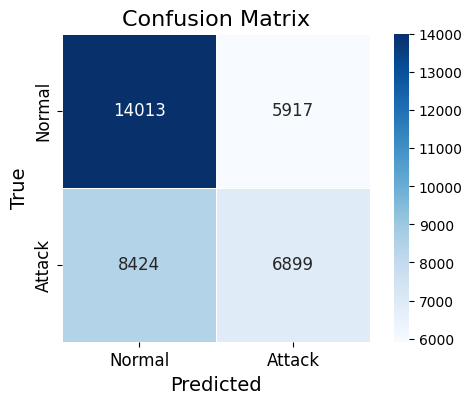

In [26]:
# measure the performance of the model on all the features
dt_all = evaluate_model(dt, X_train, X_test, y_train, y_test)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



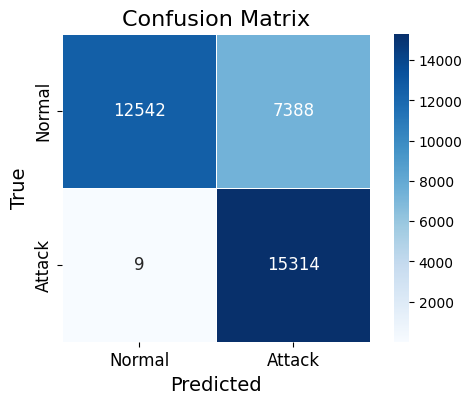

In [27]:
# measure the performance of the model on the top 8 features of the mutual information scores
dt_MI = evaluate_model(dt, X_train[MI_features], X_test[MI_features], y_train, y_test)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



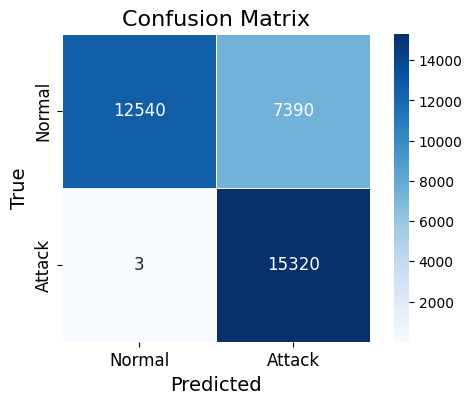

In [28]:
# measure the performance of the model on the top 8 features of the ANOVA F-scores
dt_ANOVA = evaluate_model(
    dt, X_train[ANOVA_features], X_test[ANOVA_features], y_train, y_test
)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



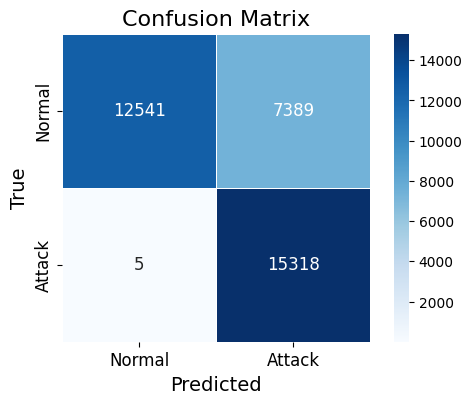

In [29]:
# measure the performance of the model on the top 8 features of the chi2 scores
dt_chi2 = evaluate_model(
    dt, X_train[chi2_features], X_test[chi2_features], y_train, y_test
)

## XGB

In [30]:
# Initialize the model
xgb = XGBClassifier(random_state=42)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.68      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



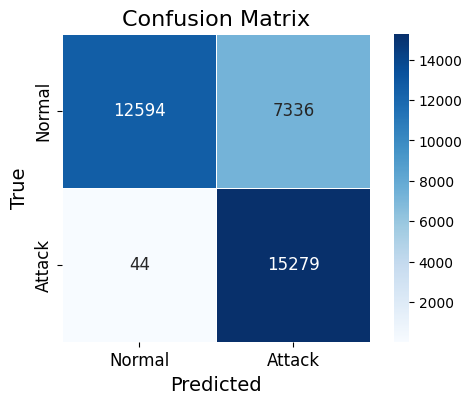

In [31]:
# measure the performance of the model on all the features
xgb_all = evaluate_model(xgb, X_train, X_test, y_train, y_test)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



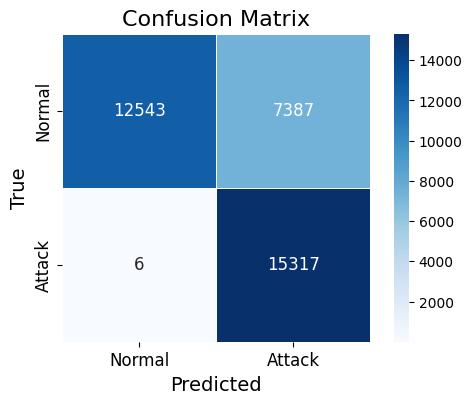

In [32]:
# measure the performance of the model on the top 8 features of the mutual information scores
xgb_MI = evaluate_model(xgb, X_train[MI_features], X_test[MI_features], y_train, y_test)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



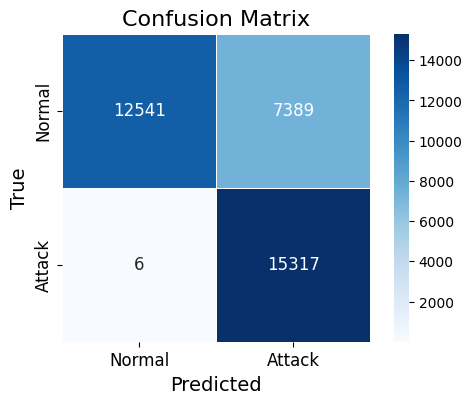

In [33]:
# measure the performance of the model on the top 8 features of the ANOVA F-scores
xgb_ANOVA = evaluate_model(
    xgb, X_train[ANOVA_features], X_test[ANOVA_features], y_train, y_test
)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



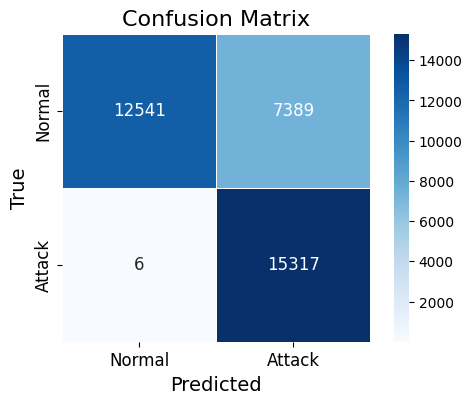

In [34]:
# measure the performance of the model on the top 8 features of the chi2 scores
xgb_chi2 = evaluate_model(
    xgb, X_train[chi2_features], X_test[chi2_features], y_train, y_test
)

## Compare Models

### Accuracy Table

In [35]:
# accuracy table
models = ["Decision Tree", "XGBoost"]
acc_all = [dt_all[0], xgb_all[0]]
acc_MI = [dt_MI[0], xgb_MI[0]]
acc_ANOVA = [dt_ANOVA[0], xgb_ANOVA[0]]
acc_Chi = [dt_chi2[0], xgb_chi2[0]]

acc_table = PrettyTable()
acc_table.title = "Accuracy"
acc_table.field_names = [
    "Model",
    "All Features",
    "MI Features",
    "ANOVA Features",
    "Chi2 Features",
]

for model, acc_all, acc_MI, acc_ANOVA, acc_Chi in zip(
    models, acc_all, acc_MI, acc_ANOVA, acc_Chi
):
    acc_table.add_row(
        [model, f"{acc_all:.5f}", f"{acc_MI:.5f}", f"{acc_ANOVA:.5f}", f"{acc_Chi:.5f}"]
    )

print(acc_table)

+-----------------------------------------------------------------------------+
|                                   Accuracy                                  |
+---------------+--------------+-------------+----------------+---------------+
|     Model     | All Features | MI Features | ANOVA Features | Chi2 Features |
+---------------+--------------+-------------+----------------+---------------+
| Decision Tree |   0.59320    |   0.79017   |    0.79029     |    0.79026    |
|    XGBoost    |   0.79066    |   0.79029   |    0.79023     |    0.79023    |
+---------------+--------------+-------------+----------------+---------------+


### F1-Score Table

In [36]:
# F1 table
models = [
    "Decision Tree",
    "XGBoost",
]
f1_all = [dt_all[1], xgb_all[1]]
f1_MI = [dt_MI[1], xgb_MI[1], [1]]
f1_ANOVA = [dt_ANOVA[1], xgb_ANOVA[1]]
f1_Chi = [dt_chi2[1], xgb_chi2[1]]

f1_table = PrettyTable()
f1_table.title = "F1"
f1_table.field_names = [
    "Model",
    "All Features",
    "MI Features",
    "ANOVA Features",
    "Chi2 Features",
]

for model, f1_all, f1_MI, f1_ANOVA, f1_Chi in zip(
    models, f1_all, f1_MI, f1_ANOVA, f1_Chi
):
    f1_table.add_row(
        [model, f"{f1_all:.5f}", f"{f1_MI:.5f}", f"{f1_ANOVA:.5f}", f"{f1_Chi:.5f}"]
    )

print(f1_table)

+-----------------------------------------------------------------------------+
|                                      F1                                     |
+---------------+--------------+-------------+----------------+---------------+
|     Model     | All Features | MI Features | ANOVA Features | Chi2 Features |
+---------------+--------------+-------------+----------------+---------------+
| Decision Tree |   0.49035    |   0.80547   |    0.80562     |    0.80557    |
|    XGBoost    |   0.80547    |   0.80559   |    0.80554     |    0.80554    |
+---------------+--------------+-------------+----------------+---------------+


### Recall Table

In [37]:
# Recall table
models = ["Decision Tree", "XGBoost"]
recall_all = [dt_all[2], xgb_all[2]]
recall_MI = [dt_MI[2], xgb_MI[2]]
recall_ANOVA = [dt_ANOVA[2], xgb_ANOVA[2]]
recall_Chi = [dt_chi2[2], xgb_chi2[2]]

recall_table = PrettyTable()
recall_table.title = "Recall"
recall_table.field_names = [
    "Model",
    "All Features",
    "MI Features",
    "ANOVA Features",
    "Chi2 Features",
]

for model, recall_all, recall_MI, recall_ANOVA, recall_Chi in zip(
    models, recall_all, recall_MI, recall_ANOVA, recall_Chi
):
    recall_table.add_row(
        [
            model,
            f"{recall_all:.5f}",
            f"{recall_MI:.5f}",
            f"{recall_ANOVA:.5f}",
            f"{recall_Chi:.5f}",
        ]
    )

print(recall_table)

+-----------------------------------------------------------------------------+
|                                    Recall                                   |
+---------------+--------------+-------------+----------------+---------------+
|     Model     | All Features | MI Features | ANOVA Features | Chi2 Features |
+---------------+--------------+-------------+----------------+---------------+
| Decision Tree |   0.45024    |   0.99941   |    0.99980     |    0.99967    |
|    XGBoost    |   0.99713    |   0.99961   |    0.99961     |    0.99961    |
+---------------+--------------+-------------+----------------+---------------+


### Precision Table

In [38]:
# Percision table
models = ["Decision Tree", "XGBoost"]
percision_all = [dt_all[3], xgb_all[3]]
percision_MI = [dt_MI[3], xgb_MI[3]]
percision_ANOVA = [dt_ANOVA[3], xgb_ANOVA[3]]
percision_Chi = [dt_chi2[3], xgb_chi2[3]]

percision_table = PrettyTable()
percision_table.title = "Percision"
percision_table.field_names = [
    "Model",
    "All Features",
    "MI Features",
    "ANOVA Features",
    "Chi2 Features",
]

for model, percision_all, percision_MI, percision_ANOVA, percision_Chi in zip(
    models, percision_all, percision_MI, percision_ANOVA, percision_Chi
):
    percision_table.add_row(
        [
            model,
            f"{percision_all:.5f}",
            f"{percision_MI:.5f}",
            f"{percision_ANOVA:.5f}",
            f"{percision_Chi:.5f}",
        ]
    )

print(percision_table)

+-----------------------------------------------------------------------------+
|                                  Percision                                  |
+---------------+--------------+-------------+----------------+---------------+
|     Model     | All Features | MI Features | ANOVA Features | Chi2 Features |
+---------------+--------------+-------------+----------------+---------------+
| Decision Tree |   0.53831    |   0.67457   |    0.67459     |    0.67459    |
|    XGBoost    |   0.67561    |   0.67464   |    0.67458     |    0.67458    |
+---------------+--------------+-------------+----------------+---------------+


## Discussion

* **After comparing the models, the highest F1 score for `XGB` was with the `Mutual Information` features and the highest F1 score for `Decision Tree` was with the `ANOVA` features.**


* **The best 8 features selected by `Mutual Information` are:**
**`[sld - labels - special - entropy - FQDN_count - lower - labels_average - labels_max]`**

* **The best 8 features selected by `ANOVA` are:**
**`[numeric - special - sld - subdomain_length - labels - FQDN_count - subdomain - longest_word]`**

# Fine Tuning

## Decision Tree

In [39]:
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    "max_depth": [12, 13, 15, 17, 18, 20, 21],
    "min_samples_split": [7, 9, 10, 11, 12, 13, 15],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train[ANOVA_features], y_train)
dt = grid_search.best_estimator_

# Get the best hyperparameters
dt_tuned = grid_search.best_score_
print("Best Hyperparameters:\n", grid_search.best_params_)
print("Best F1 score:\n", dt_tuned)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


Best Hyperparameters:
 {'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best F1 score:
 0.8035175581849824


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



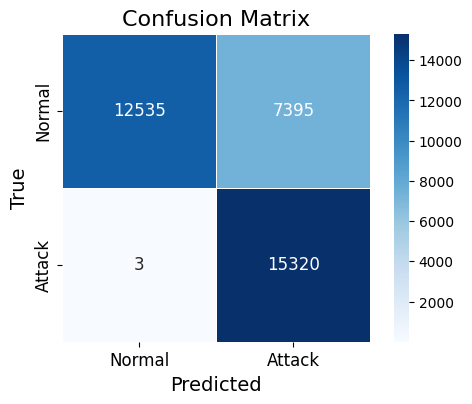

Accuracy:  0.7901455195302527
F1:  0.8055102791944897
Recall:  0.9998042158846179
Percision:  0.6744441998679287


In [88]:
dt_acc, dt_f1, dt_recall, dt_percision = evaluate_model(
    dt, X_train[ANOVA_features], X_test[ANOVA_features], y_train, y_test
)
print("Accuracy: ", dt_acc)
print("F1: ", dt_f1)
print("Recall: ", dt_recall)
print("Percision: ", dt_percision)

## XGBoost

In [50]:
xgb = XGBClassifier(random_state=42)

param_grid = {
    "max_depth": [3, 5, 7, 8, 9],
    "learning_rate": [0.001, 0.01, 0.1, 0.15],
    "gamma": [0, 0.25, 1.0],
    "reg_lambda": [0, 1.0, 10.0],
    "scale_pos_weight": [1, 3, 5],
    "n_estimators": [100, 150, 200, 250],
}

grid_search = GridSearchCV(
    estimator=xgb, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1, verbose=2
)
grid_search.fit(X_train[MI_features], y_train)
xgb = grid_search.best_estimator_


# Get the best hyperparameters
xgb_tuned = grid_search.best_score_
print("Best Hyperparameters:\n", grid_search.best_params_)
print("Best F1 score:\n", xgb_tuned)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
Best Hyperparameters:
 {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150, 'reg_lambda': 10.0, 'scale_pos_weight': 5}
Best F1 score:
 0.8034985165809607


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.63      0.77     19930
           1       0.67      1.00      0.81     15323

    accuracy                           0.79     35253
   macro avg       0.84      0.81      0.79     35253
weighted avg       0.86      0.79      0.79     35253



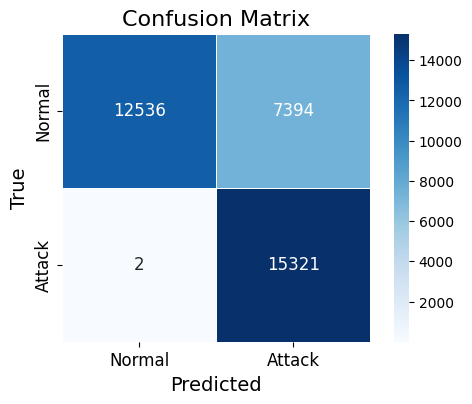

Accuracy:  0.7902022522905852
F1:  0.8055628581944372
Recall:  0.999869477256412
Percision:  0.674488223640766


In [89]:
xgb_acc, xgb_f1, xgb_recall, xgb_percision = evaluate_model(
    xgb, X_train[MI_features], X_test[MI_features], y_train, y_test
)
print("Accuracy: ", xgb_acc)
print("F1: ", xgb_f1)
print("Recall: ", xgb_recall)
print("Percision: ", xgb_percision)

## Comparison

In [91]:
# compare tuned models
models = ["Decision Tree", "XGBoost"]
acc_all = [dt_acc, xgb_acc]
f1_all = [dt_f1, xgb_f1]
recall_all = [dt_recall, xgb_recall]
percision_all = [dt_percision, xgb_percision]

tuned_table = PrettyTable()
tuned_table.title = "Tuned Models on test data"
tuned_table.field_names = [
    "Model",
    "Accuracy",
    "F1",
    "Recall",
    "Percision",
]

for model, acc_all, f1_all, recall_all, percision_all in zip(
    models, acc_all, f1_all, recall_all, percision_all
):
    tuned_table.add_row(
        [
            model,
            f"{acc_all:.5f}",
            f"{f1_all:.5f}",
            f"{recall_all:.5f}",
            f"{percision_all:.5f}",
        ]
    )

print(tuned_table)

+----------------------------------------------------------+
|                Tuned Models on test data                 |
+---------------+----------+---------+---------+-----------+
|     Model     | Accuracy |    F1   |  Recall | Percision |
+---------------+----------+---------+---------+-----------+
| Decision Tree | 0.79015  | 0.80551 | 0.99980 |  0.67444  |
|    XGBoost    | 0.79020  | 0.80556 | 0.99987 |  0.67449  |
+---------------+----------+---------+---------+-----------+


## Discussion


* **The `XGB` model is slightly better than the `Decision Tree` model on all metrics except for a slight decrease in recall.** 
* **The champion model is the `XGB` model with the Mutual Information features.**

# Pipeline

In [96]:
pipe = Pipeline(
    [
        ("scaler", scaler),
        ("classifier", xgb),
    ]
)

with open("model.pkl", "wb") as file:
    pickle.dump(pipe, file)